# Word2Vec

Using only the raw text, we'll derive and explore the semantic properties of its words.

## Imports

Python code in one module gains access to the code in another module by the process of importing it. The import statement is the most common way of invoking the import machinery, but it is not the only way.

In [1]:
from __future__ import absolute_import, division, print_function

In [2]:
import codecs
import glob
import logging
import multiprocessing
import os
import pprint
import re

In [3]:
import nltk
import gensim.models.word2vec as w2v
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


**Set up logging**

In [5]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

**Download NLTK tokenizer models (only the first time)**

In [6]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /Users/keno/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/keno/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Prepare Corpus

**Load books from files**

In [7]:
book_filenames = sorted(glob.glob("txtdata/*.txt"))

In [8]:
print("Found books:")
book_filenames

Found books:


['txtdata/aufbauhaus.txt',
 'txtdata/bauhausbuch1.txt',
 'txtdata/staatlichesbauhaus.txt']

**Combine the books into one string**

In [9]:
corpus_raw = u""
for book_filename in book_filenames:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print()

Reading 'txtdata/aufbauhaus.txt'...
Corpus is now 41836 characters long

Reading 'txtdata/bauhausbuch1.txt'...
Corpus is now 48293 characters long

Reading 'txtdata/staatlichesbauhaus.txt'...
Corpus is now 56552 characters long



**Split the corpus into sentences**

In [10]:
tokenizer = nltk.data.load('tokenizers/punkt/german.pickle')

In [11]:
raw_sentences = tokenizer.tokenize(corpus_raw)

In [12]:
#convert into a list of words
#rtemove unnnecessary,, split into words, no hyphens
#list of words
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

In [13]:
#sentence where each word is tokenized
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [14]:
print(raw_sentences[5])
print(sentence_to_wordlist(raw_sentences[5]))

Solange aber die Wirtschaft, die Maschine Selbstzweck sind, anstatt Mittel, ^ die Geisteskräfte zunehmend von mechanischer Arbeitslast zu befreien, bleibt der Einzelne unfrei und die Gesellschaft kann sich nicht ordnen.
['Solange', 'aber', 'die', 'Wirtschaft', 'die', 'Maschine', 'Selbstzweck', 'sind', 'anstatt', 'Mittel', 'die', 'Geisteskr', 'fte', 'zunehmend', 'von', 'mechanischer', 'Arbeitslast', 'zu', 'befreien', 'bleibt', 'der', 'Einzelne', 'unfrei', 'und', 'die', 'Gesellschaft', 'kann', 'sich', 'nicht', 'ordnen']


In [15]:
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 8,369 tokens


## Train Word2Vec

In [16]:
#ONCE we have vectors
#step 3 - build model
#3 main tasks that vectors help with
#DISTANCE, SIMILARITY, RANKING

# Dimensionality of the resulting word vectors.
#more dimensions, more computationally expensive to train
#but also more accurate
#more dimensions = more generalized
num_features = 300
# Minimum word count threshold.
min_word_count = 3

# Number of threads to run in parallel.
#more workers, faster we train
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 7

# Downsample setting for frequent words.
#0 - 1e-5 is good for this
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
#random number generator
#deterministic, good for debugging
seed = 1

In [17]:
thrones2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [18]:
thrones2vec.build_vocab(sentences)

2019-10-24 12:12:40,172 : INFO : collecting all words and their counts
2019-10-24 12:12:40,176 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-10-24 12:12:40,184 : INFO : collected 2601 word types from a corpus of 8369 raw words and 328 sentences
2019-10-24 12:12:40,185 : INFO : Loading a fresh vocabulary
2019-10-24 12:12:40,196 : INFO : effective_min_count=3 retains 549 unique words (21% of original 2601, drops 2052)
2019-10-24 12:12:40,200 : INFO : effective_min_count=3 leaves 5885 word corpus (70% of original 8369, drops 2484)
2019-10-24 12:12:40,221 : INFO : deleting the raw counts dictionary of 2601 items
2019-10-24 12:12:40,222 : INFO : sample=0.001 downsamples 70 most-common words
2019-10-24 12:12:40,231 : INFO : downsampling leaves estimated 4029 word corpus (68.5% of prior 5885)
2019-10-24 12:12:40,235 : INFO : estimated required memory for 549 words and 300 dimensions: 1592100 bytes
2019-10-24 12:12:40,245 : INFO : resetting layer weights


In [19]:
print("Word2Vec vocabulary length:", len(thrones2vec.wv.vocab))

Word2Vec vocabulary length: 549


**Start training, this might take a minute or two...**

In [20]:
thrones2vec.train(sentences, total_words=token_count, epochs = 100 )

2019-10-24 12:12:40,419 : INFO : training model with 4 workers on 549 vocabulary and 300 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
2019-10-24 12:12:40,423 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-10-24 12:12:40,425 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-10-24 12:12:40,426 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-10-24 12:12:40,471 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-10-24 12:12:40,472 : INFO : EPOCH - 1 : training on 8369 raw words (3991 effective words) took 0.1s, 79053 effective words/s
2019-10-24 12:12:40,477 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-10-24 12:12:40,478 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-10-24 12:12:40,479 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-10-24 12:12:40,511 : INFO : worker thread finished; awaiting finish of 0 more th

2019-10-24 12:12:41,179 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-10-24 12:12:41,211 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-10-24 12:12:41,212 : INFO : EPOCH - 17 : training on 8369 raw words (4058 effective words) took 0.0s, 108719 effective words/s
2019-10-24 12:12:41,218 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-10-24 12:12:41,219 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-10-24 12:12:41,220 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-10-24 12:12:41,253 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-10-24 12:12:41,254 : INFO : EPOCH - 18 : training on 8369 raw words (4055 effective words) took 0.0s, 107132 effective words/s
2019-10-24 12:12:41,259 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-10-24 12:12:41,260 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-10-

2019-10-24 12:12:41,761 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-10-24 12:12:41,762 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-10-24 12:12:41,762 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-10-24 12:12:41,792 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-10-24 12:12:41,792 : INFO : EPOCH - 34 : training on 8369 raw words (3965 effective words) took 0.0s, 124615 effective words/s
2019-10-24 12:12:41,797 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-10-24 12:12:41,798 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-10-24 12:12:41,799 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-10-24 12:12:41,840 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-10-24 12:12:41,842 : INFO : EPOCH - 35 : training on 8369 raw words (4041 effective words) took 0.0s, 91666 effective words/s
2019-10-2

2019-10-24 12:12:42,418 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-10-24 12:12:42,419 : INFO : EPOCH - 50 : training on 8369 raw words (4054 effective words) took 0.0s, 142039 effective words/s
2019-10-24 12:12:42,424 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-10-24 12:12:42,424 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-10-24 12:12:42,425 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-10-24 12:12:42,449 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-10-24 12:12:42,449 : INFO : EPOCH - 51 : training on 8369 raw words (4033 effective words) took 0.0s, 144299 effective words/s
2019-10-24 12:12:42,454 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-10-24 12:12:42,455 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-10-24 12:12:42,455 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-10-

2019-10-24 12:12:42,947 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-10-24 12:12:42,948 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-10-24 12:12:42,975 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-10-24 12:12:42,976 : INFO : EPOCH - 67 : training on 8369 raw words (4002 effective words) took 0.0s, 137342 effective words/s
2019-10-24 12:12:42,980 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-10-24 12:12:42,981 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-10-24 12:12:42,981 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-10-24 12:12:43,008 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-10-24 12:12:43,009 : INFO : EPOCH - 68 : training on 8369 raw words (3992 effective words) took 0.0s, 140268 effective words/s
2019-10-24 12:12:43,013 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-10-

2019-10-24 12:12:43,494 : INFO : EPOCH - 83 : training on 8369 raw words (4008 effective words) took 0.0s, 156703 effective words/s
2019-10-24 12:12:43,498 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-10-24 12:12:43,501 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-10-24 12:12:43,502 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-10-24 12:12:43,526 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-10-24 12:12:43,527 : INFO : EPOCH - 84 : training on 8369 raw words (3981 effective words) took 0.0s, 136850 effective words/s
2019-10-24 12:12:43,531 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-10-24 12:12:43,534 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-10-24 12:12:43,535 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-10-24 12:12:43,560 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-10-

2019-10-24 12:12:44,048 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-10-24 12:12:44,073 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-10-24 12:12:44,074 : INFO : EPOCH - 100 : training on 8369 raw words (4021 effective words) took 0.0s, 148510 effective words/s
2019-10-24 12:12:44,074 : INFO : training on a 836900 raw words (402267 effective words) took 3.7s, 110073 effective words/s


(402267, 836900)

**Save to file, can be useful later**

In [21]:
if not os.path.exists("trained"):
    os.makedirs("trained")

In [22]:
thrones2vec.save(os.path.join("trained", "thrones2vec.w2v"))

2019-10-24 12:12:44,092 : INFO : saving Word2Vec object under trained/thrones2vec.w2v, separately None
2019-10-24 12:12:44,094 : INFO : not storing attribute vectors_norm
2019-10-24 12:12:44,094 : INFO : not storing attribute cum_table
2019-10-24 12:12:44,114 : INFO : saved trained/thrones2vec.w2v


## Explore the trained model.

In [23]:
print(thrones2vec.most_similar('Wirtschaft', topn=5))

/Users/keno/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2019-10-24 12:12:44,156 : INFO : precomputing L2-norms of word weight vectors


[('Ausnutzung', 0.72625333070755), ('bestimmt', 0.6324504613876343), ('Stoff', 0.6029125452041626), ('Mitteln', 0.5750613808631897), ('entscheidend', 0.5714749097824097)]


### Compress the word vectors into 2D space and plot them

In [24]:
#my video - how to visualize a dataset easily
tsne = sklearn.manifold.TSNE(n_components=3, random_state=0)

In [25]:
all_word_vectors_matrix = thrones2vec.wv.syn0

/Users/keno/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  """Entry point for launching an IPython kernel.


**Train t-SNE, this could take a minute or two...**

In [26]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

**Plot the big picture**

In [27]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1], coords[2])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[thrones2vec.wv.vocab[word].index])
            for word in thrones2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y", "z"]
)

In [28]:
points.head(100)

,word,x,y,z
0,Die,25.403320,-88.592804,-13.296743
1,Idee,-83.306152,80.093506,26.662247
2,der,8.725956,-80.876465,0.288355
3,heutigen,66.258835,28.833122,50.398899
4,Welt,71.181175,7.575411,76.836868
...,...,...,...,...
95,F,63.857643,-57.550545,-27.682753
96,ihnen,93.118370,-93.359032,-66.553978
97,gleichzeitig,24.373436,-53.925816,-14.540432
98,oder,-151.203568,5.418438,-16.714619


In [29]:
sns.set_context("poster")

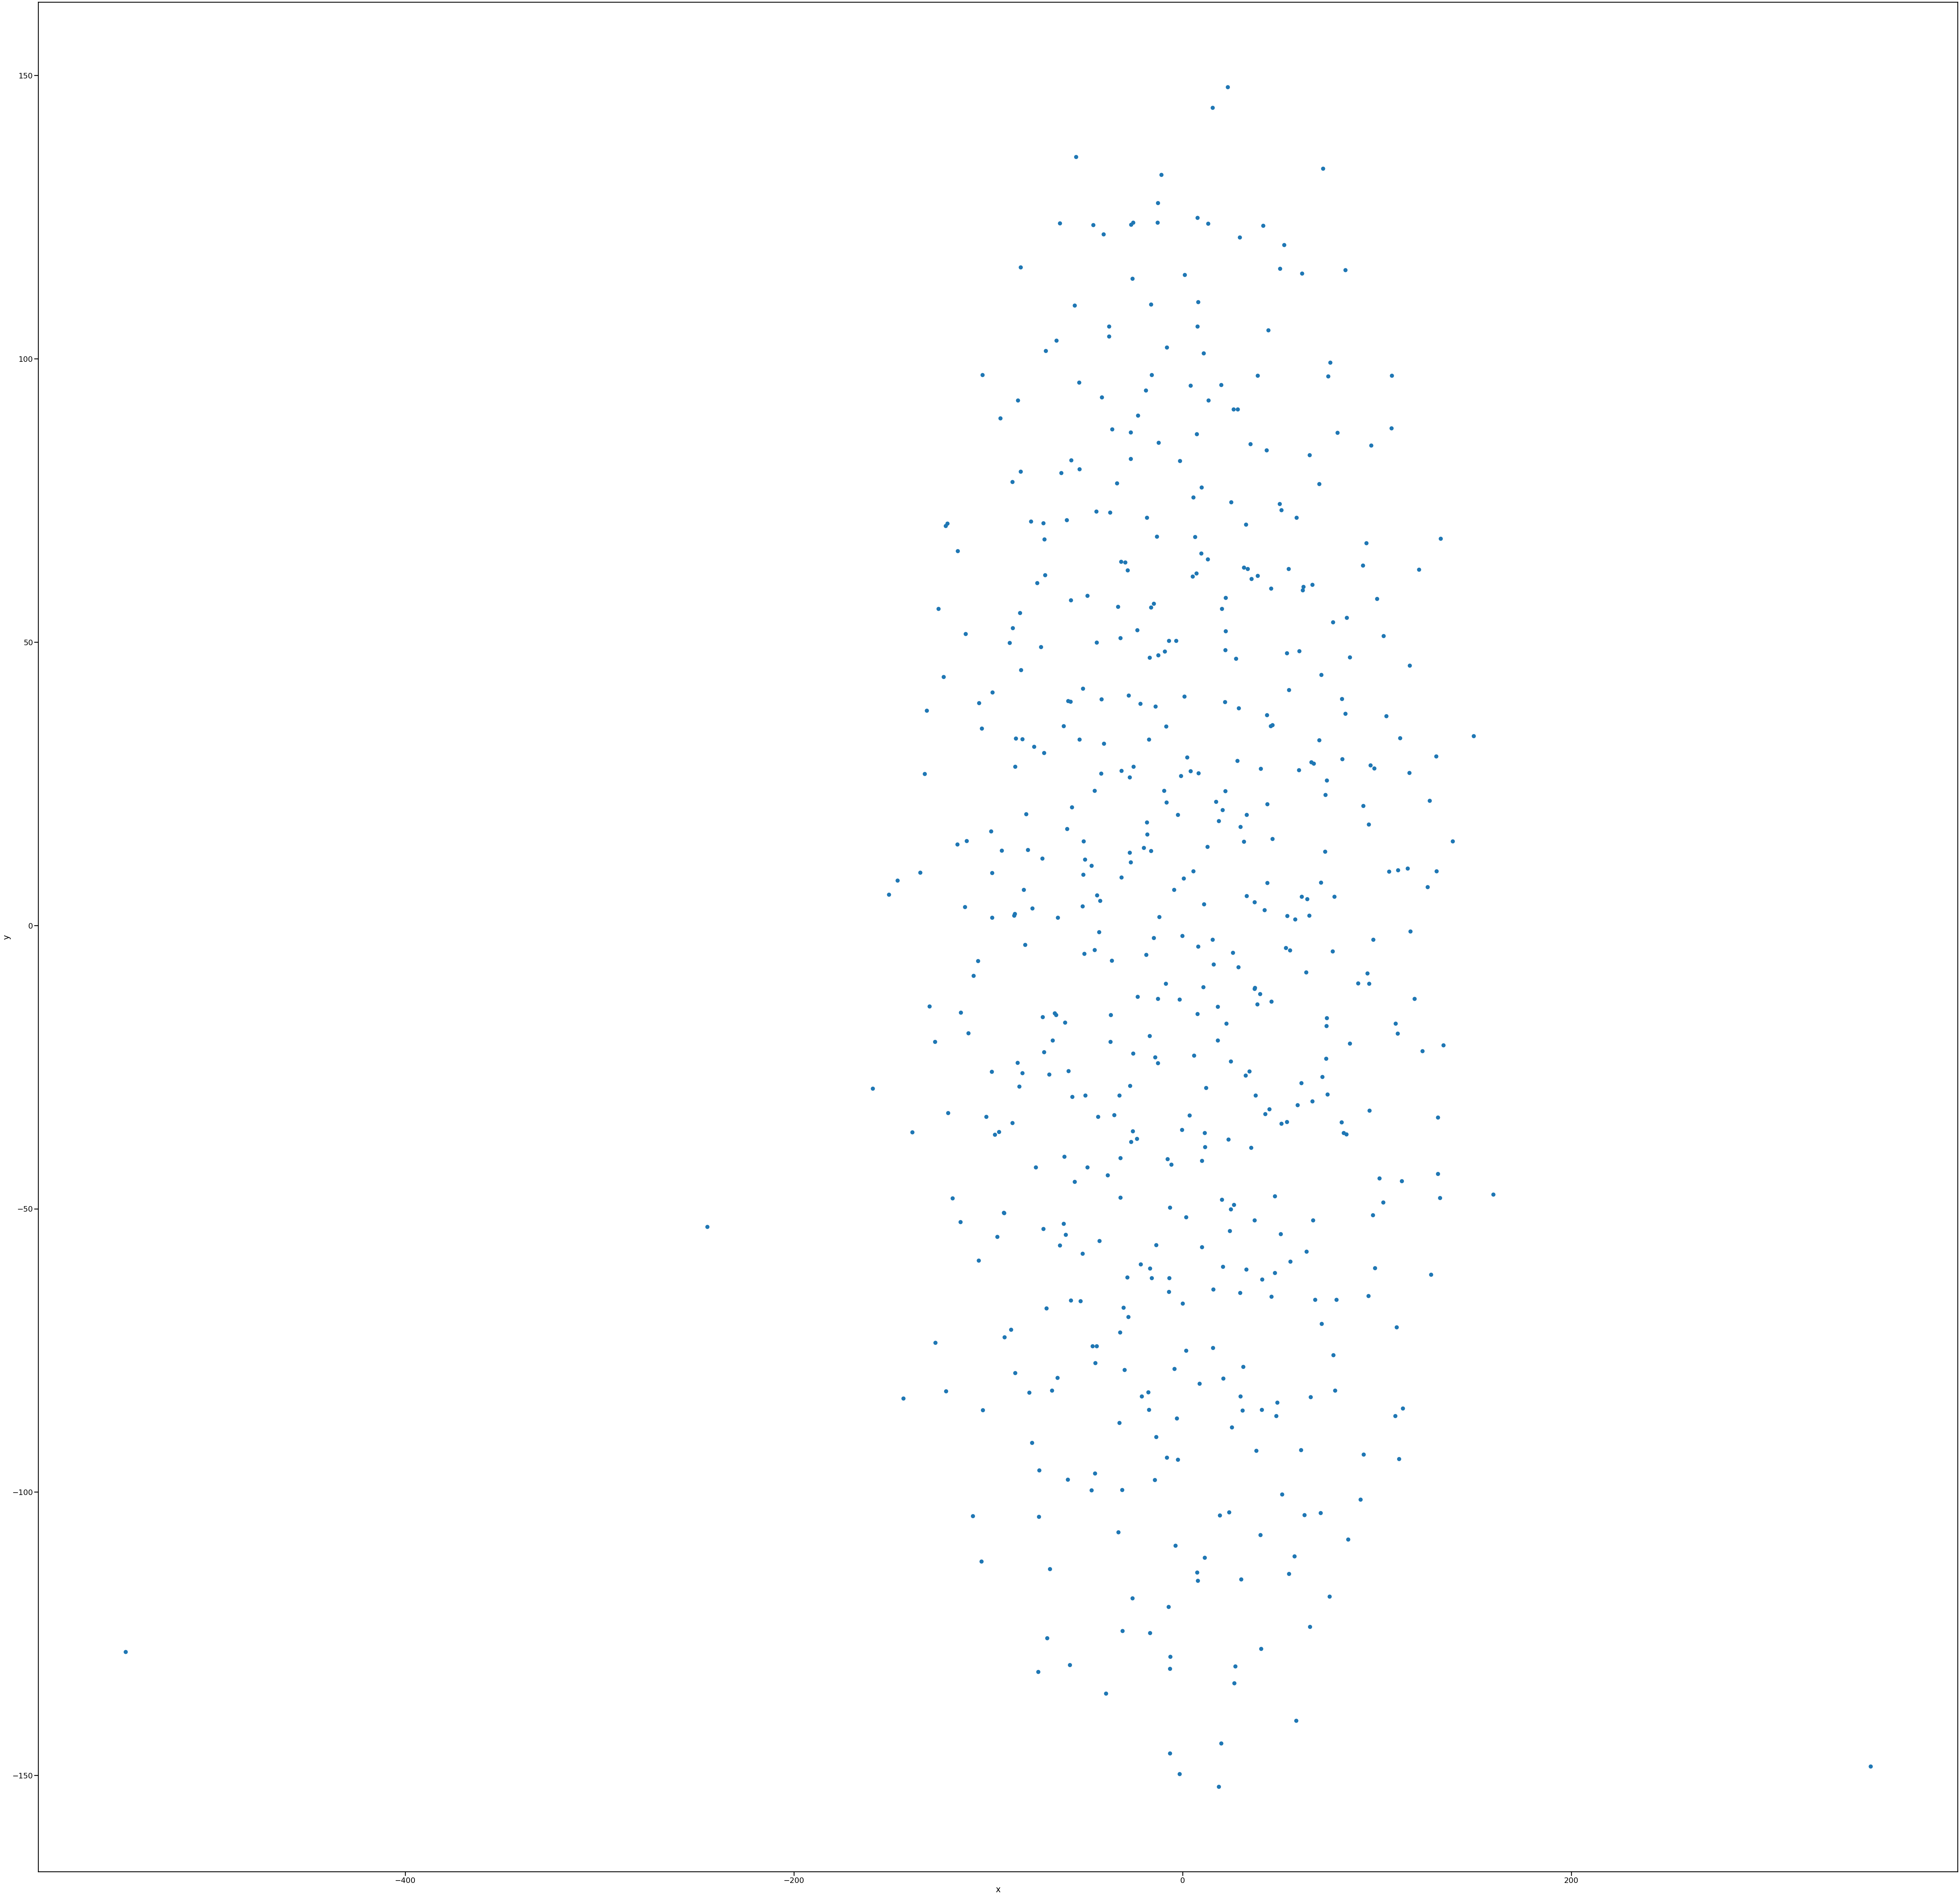

In [30]:
points.plot.scatter("x", "y", s=100, figsize=(100, 100))

### Explore semantic similarities between book characters

**Words closest to the given word**

In [31]:
thrones2vec.most_similar("Wirtschaft")

/Users/keno/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('Ausnutzung', 0.72625333070755),
 ('bestimmt', 0.6324504613876343),
 ('Stoff', 0.6029125452041626),
 ('Mitteln', 0.5750613808631897),
 ('entscheidend', 0.5714749097824097),
 ('Maschine', 0.5693711042404175),
 ('Forderungen', 0.5257004499435425),
 ('Selbstzweck', 0.5182530879974365),
 ('ten', 0.5089693069458008),
 ('Wissen', 0.5086621046066284)]

In [32]:
thrones2vec.most_similar("Bauhaus")

/Users/keno/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('Weimar', 0.5588447451591492),
 ('unter', 0.5337015390396118),
 ('Staatlichen', 0.5330178141593933),
 ('begonnen', 0.5329424142837524),
 ('Das', 0.5300936698913574),
 ('hat', 0.5204504728317261),
 ('Arbeiten', 0.49157705903053284),
 ('user', 0.46510931849479675),
 ('ehemaligen', 0.45240074396133423),
 ('herzoglich', 0.44853639602661133)]

In [33]:
thrones2vec.most_similar("Studierenden")

/Users/keno/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('Maler', 0.6318807601928711),
 ('Bildhauer', 0.6179627180099487),
 ('Arbeiten', 0.6176242232322693),
 ('Mitarbeit', 0.6122339963912964),
 ('fremden', 0.6063392758369446),
 ('ge', 0.5900108814239502),
 ('sollen', 0.5820778608322144),
 ('ndliche', 0.580025851726532),
 ('Werkst', 0.5755552649497986),
 ('Meistern', 0.5742306113243103)]

**Linear relationships between word pairs**

In [34]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = thrones2vec.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [41]:
nearest_similarity_cosmul("Bauhaus", "Weimar", "Studierenden")
nearest_similarity_cosmul("Bauhaus", "Weimar", "Architekten")
nearest_similarity_cosmul("Form", "Tempo", "Meister")

Bauhaus is related to Weimar, as Meistern is related to Studierenden
Bauhaus is related to Weimar, as will is related to Architekten
Form is related to Tempo, as bei is related to Meister


/Users/keno/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `most_similar_cosmul` (Method will be removed in 4.0.0, use self.wv.most_similar_cosmul() instead).
  after removing the cwd from sys.path.


'bei'

In [36]:
thrones2vec.most_similar(positive=['Bauhaus'], negative=['Studierenden'])

/Users/keno/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('dagegen', 0.29541271924972534),
 ('hat', 0.277190625667572),
 ('Das', 0.25454413890838623),
 ('eines', 0.24161812663078308),
 ('Im', 0.23802366852760315),
 ('Werkes', 0.2333838939666748),
 ('alte', 0.2312314212322235),
 ('Bewu', 0.22755351662635803),
 ('Leben', 0.2258937656879425),
 ('ihrem', 0.22453051805496216)]

In [37]:
thrones2vec.most_similar(positive=['Lehre'], negative=['Meister'])

/Users/keno/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('stofflichen', 0.4136160612106323),
 ('Grund', 0.3696770966053009),
 ('Versuchsarbeit', 0.3528437316417694),
 ('Durchf', 0.34672296047210693),
 ('Kenntnis', 0.32922661304473877),
 ('Umfang', 0.3206193745136261),
 ('spekulative', 0.30450278520584106),
 ('alte', 0.2915288805961609),
 ('liegt', 0.2882195711135864),
 ('entscheidend', 0.2717995047569275)]